### Offense-Defense Custom Rating

#### Libraries

In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)
library(tidyimpute,warn.conflicts=F)

library(psych,warn.conflicts=F)
library(ggplot2,warn.conflicts=F)

#### Load 2011+

In [2]:
# load the stats
data.regulars <- readRDS('../datafiles_rds/RegularSeasonDetailedResults.rds')
# keep 2011+
data.regulars %>% filter(Season>2010) -> data.regulars

In [3]:
# load the stats
data.teams <- readRDS('../datafiles_rds/Teams.rds')

data.teams %>%
    select(TeamID,TeamName) %>%
    mutate(TeamName=str_to_lower(TeamName), 
           TeamName=str_replace_all(TeamName,' ','_'), 
           TeamName=str_remove_all(TeamName,'&')) -> df.teams

#### Prepare data

In [4]:
data.regulars %>% dim %>% cat
data.regulars %>% head

42704 34

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,⋯,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2011,7,1228,79,1414,65,H,0,29,58,⋯,20,14,22,11,26,12,14,7,1,21
2011,7,1268,105,1370,76,H,0,35,62,⋯,16,17,22,18,16,11,27,18,1,31
2011,7,1338,83,1348,75,H,0,29,64,⋯,32,13,16,10,21,16,17,7,6,25
2011,7,1400,83,1298,52,H,0,30,59,⋯,23,10,18,8,22,8,16,5,5,24
2011,9,1228,84,1405,45,H,0,37,64,⋯,12,10,19,6,17,9,23,6,0,14
2011,9,1268,75,1158,74,H,0,34,66,⋯,20,16,19,11,25,12,22,8,8,19


In [5]:
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_replace(.,'L','O'))) %>%
    rename_at(vars(starts_with('W')),list(~str_remove(.,'W'))) %>%
    mutate(OLoc=case_when(Loc=='H' ~ 'A', Loc=='A' ~ 'H', TRUE ~ 'N')) -> group1
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_remove(.,'L'))) %>%
    rename_at(vars(starts_with('W')),list(~str_replace(.,'W','O'))) %>%
    mutate(Loc=case_when(OLoc=='H' ~ 'A', OLoc=='A' ~ 'H', TRUE ~ 'N')) -> group2
group1 %>% bind_rows(group2) -> df.regulars

In [6]:
df.regulars %>% dim %>% cat('\n')
df.regulars %>% arrange(Season,DayNum) %>% head

85408 35 


Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,OLoc
2011,7,1228,79,1414,65,H,0,29,58,⋯,14,22,11,26,12,14,7,1,21,A
2011,7,1268,105,1370,76,H,0,35,62,⋯,17,22,18,16,11,27,18,1,31,A
2011,7,1338,83,1348,75,H,0,29,64,⋯,13,16,10,21,16,17,7,6,25,A
2011,7,1400,83,1298,52,H,0,30,59,⋯,10,18,8,22,8,16,5,5,24,A
2011,7,1414,65,1228,79,A,0,22,63,⋯,13,23,9,30,17,14,9,8,22,H
2011,7,1370,76,1268,105,A,0,28,77,⋯,33,41,17,33,23,29,9,9,20,H


In [7]:
df.regulars %>%
    left_join(df.teams %>% rename(OTeamName=TeamName),by=c('OTeamID'='TeamID')) %>%
    left_join(df.teams,by='TeamID') -> df.regulars

In [8]:
# Check
data.regulars %>% filter(Season==2014,WTeamID==1103,DayNum==4) %>% select(Season:NumOT)
df.regulars %>% filter(TeamID==1103 | OTeamID==1103,DayNum==4,Season==2014)

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2014,4,1103,72,1157,63,H,0


Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,OLoc,OTeamName,TeamName
2014,4,1103,72,1157,63,H,0,25,59,⋯,15,22,6,20,8,4,22,A,coastal_car,akron
2014,4,1157,63,1103,72,A,0,23,59,⋯,14,24,10,17,13,5,18,H,akron,coastal_car


#### Stat matrix

In [9]:
CreateMatrix <- function(dataset,stat) {
    stat_var <- enquo(stat)
    dataset %>% rename(Statistic := !!stat_var) -> dataset
    for(i in 2011:2018) {
        dataset %>%
            filter(Season==i) %>%
            select(TeamName,OTeamName,Statistic) %>% 
            group_by(TeamName,OTeamName) %>% 
            summarise(Statistic=mean(Statistic)) %>% 
            ungroup() %>%
            spread(TeamName,Statistic) %>% 
            impute(0.01) %>% 
            select(-OTeamName) %>% 
            as.matrix() -> tmp
        dataset %>% 
            filter(Season==i) %>% 
            distinct(OTeamName) %>% 
            arrange(OTeamName) %>% 
            pull(OTeamName) -> vnames
        attr(tmp,'dimnames') <- list(vnames,vnames)
        assign(paste0('m.stat.',i), tmp, envir=.GlobalEnv)
    }
}

In [10]:
dataset <- df.regulars %>% 
    mutate(Poss=FGA+0.475*FTA-OR+TO,ScorePoss=Score/Poss) %>%
    mutate(OPoss=OFGA+0.475*OFTA-OOR+OTO,OScorePoss=OScore/OPoss) %>%
    mutate(GmS=(ScorePoss+1)/(ScorePoss+OScorePoss+2))

In [11]:
dataset %>% head

Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OBlk,OPF,OLoc,OTeamName,TeamName,Poss,ScorePoss,OPoss,OScorePoss,GmS
2011,7,1228,79,1414,65,H,0,29,58,⋯,1,21,A,uc_irvine,illinois,73.925,1.068651,76.450,0.8502289,0.5278679
2011,7,1268,105,1370,76,H,0,35,62,⋯,1,31,A,seattle,maryland,93.475,1.123295,96.450,0.7879730,0.5428661
2011,7,1338,83,1348,75,H,0,29,64,⋯,6,25,A,rhode_island,pittsburgh,74.250,1.117845,74.600,1.0053619,0.5136403
2011,7,1400,83,1298,52,H,0,30,59,⋯,5,24,A,navy,texas,79.150,1.048642,79.550,0.6536769,0.5533402
2011,9,1228,84,1405,45,H,0,37,64,⋯,0,14,A,toledo,illinois,70.850,1.185603,71.025,0.6335797,0.5722699
2011,9,1268,75,1158,74,H,0,34,66,⋯,8,19,A,col_charleston,maryland,77.550,0.967118,76.025,0.9733640,0.4992075


In [12]:
CreateMatrix(dataset,GmS)
#CreateMatrix(df.regulars,Score)

####  Offense-Defense Rating

In [13]:
ComputeRating <- function(A) {
    dnow <- rep(1,nrow(A))
    for(i in 1:100) {
        dprev <- dnow
        dnow <- A %*% (1/(t(A) %*% (1/dprev)))
    }
    rdef <- as.vector(dnow)
    roff <- as.vector(t(A) %*% (1/rdef))
    rating <- as.vector(roff / rdef)
    data.frame(Team=attr(A,'dimnames')[[2]],Rating=rating,Offense=roff,Defense=rdef)
}

In [14]:
ComputeRating(m.stat.2011) %>% mutate(Season=2011) %>% mutate_if(is.factor,as.character) -> tmp2011
ComputeRating(m.stat.2012) %>% mutate(Season=2012) %>% mutate_if(is.factor,as.character) -> tmp2012
ComputeRating(m.stat.2013) %>% mutate(Season=2013) %>% mutate_if(is.factor,as.character) -> tmp2013
ComputeRating(m.stat.2014) %>% mutate(Season=2014) %>% mutate_if(is.factor,as.character) -> tmp2014
ComputeRating(m.stat.2015) %>% mutate(Season=2015) %>% mutate_if(is.factor,as.character) -> tmp2015
ComputeRating(m.stat.2016) %>% mutate(Season=2016) %>% mutate_if(is.factor,as.character) -> tmp2016
ComputeRating(m.stat.2017) %>% mutate(Season=2017) %>% mutate_if(is.factor,as.character) -> tmp2017
ComputeRating(m.stat.2018) %>% mutate(Season=2018) %>% mutate_if(is.factor,as.character) -> tmp2018

tmp2011 %>% 
    bind_rows(tmp2012) %>% 
    bind_rows(tmp2013) %>% 
    bind_rows(tmp2014) %>% 
    bind_rows(tmp2015) %>% 
    bind_rows(tmp2016) %>% 
    bind_rows(tmp2017) %>% 
    bind_rows(tmp2018) -> df.ratings

remove(list=c('tmp2011','tmp2012','tmp2013','tmp2014','tmp2015','tmp2016','tmp2017','tmp2018'))

In [15]:
df.ratings %>% arrange(desc(Rating)) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% select(Season,everything())

Season,Team,Rating,Offense,Defense
2011,ohio_st,16.14552,15.72383,0.9738821
2012,ohio_st,16.16805,16.08383,0.9947912
2013,florida,16.34808,16.28156,0.9959312
2014,arizona,16.12687,16.19201,1.0040391
2015,kentucky,16.43005,16.86496,1.0264704
2016,michigan_st,15.86044,16.41442,1.0349286
2017,gonzaga,15.98919,14.76997,0.9237477
2018,virginia,16.03642,16.38571,1.0217813


###  Regular seasons performance (train dataset)

In [16]:
data.regulars %>% 
    select(Season,WTeamID,LTeamID) %>%
    mutate(TeamID.x = ifelse(WTeamID<LTeamID,WTeamID,LTeamID), 
           TeamID.y = ifelse(WTeamID<LTeamID,LTeamID,WTeamID),
           Target = ifelse(TeamID.x==WTeamID,1,0),
           ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>%
    select(-WTeamID,-LTeamID) -> df.train

In [17]:
df.ratings %>%
    left_join(df.teams,by=c('Team'='TeamName')) -> df.ratings

In [18]:
df.train %>%
    select(-Target,-ID) %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.train.matchups

In [19]:
data.train.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2017,1238,1411,13.32279,13.85035
2014,1124,1418,15.13266,14.37742
2015,1140,1211,14.95414,15.79509
2016,1241,1456,14.48161,14.49505
2013,1142,1201,14.18198,14.25359


In [20]:
# slope hyper parameter grid : we will compute 80 models and chose the best one (min logloss)
df.ratings %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.95,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(Season,qtl) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.slopes
df.slopes %>% sample_n(5)

Season,qtl,Slope
2015,0.81,1.666557
2013,0.86,2.237126
2013,0.89,2.475017
2013,0.40,1.269553
2011,0.88,2.628856


In [21]:
data.train.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> data.train.matchups
data.train.matchups %>% dim %>% cat('\n')
data.train.matchups %>% sample_n(5)

4056880 7 


Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2012,1107,1392,14.10468,14.34717,0.04,0.9431239
2016,1293,1398,13.94911,14.02681,0.28,1.3242101
2014,1251,1347,13.61138,13.83547,0.84,2.4606879
2018,1197,1271,12.90619,12.44416,0.45,1.4848074
2012,1177,1278,14.22544,14.93399,0.13,1.0644012


In [22]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
data.train.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.train.submit
df.train.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2018,0.71,2018_1115_1374,0,0.050
2018,0.36,2018_1423_1456,0,0.346
2013,0.54,2013_1192_1384,0,0.496
2014,0.09,2014_1315_1340,0,0.479
2014,0.56,2014_1162_1189,1,0.690


In [23]:
# merge prediction and truth
df.train %>% select(ID,Target) -> data.train.truth
data.train.truth %>% inner_join(df.train.submit,by='ID') -> df.train.results

In [24]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.train.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.train.perf
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2011,0.78,6331,2291,8622,0.7342844,0.5261031
2012,0.77,6392,2161,8553,0.7473401,0.5033792
2013,0.79,6388,2344,8732,0.7315621,0.5281700
2014,0.80,6454,2394,8848,0.7294304,0.5248214
2015,0.90,6505,2453,8958,0.7261666,0.5252180
2016,0.72,6590,2385,8975,0.7342618,0.5260371
2017,0.79,6634,2379,9013,0.7360479,0.5219286
2018,0.72,6505,2508,9013,0.7217353,0.5317344


In [25]:
df.train.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018
Accuracy,0.7342844,0.7473401,0.7315621,0.7294304,0.7261666,0.7342618,0.7360479,0.7217353
Best LogLoss,0.5261031,0.5033792,0.5281700,0.5248214,0.5252180,0.5260371,0.5219286,0.5317344
Best Quantile,0.7800000,0.7700000,0.7900000,0.8000000,0.9000000,0.7200000,0.7900000,0.7200000


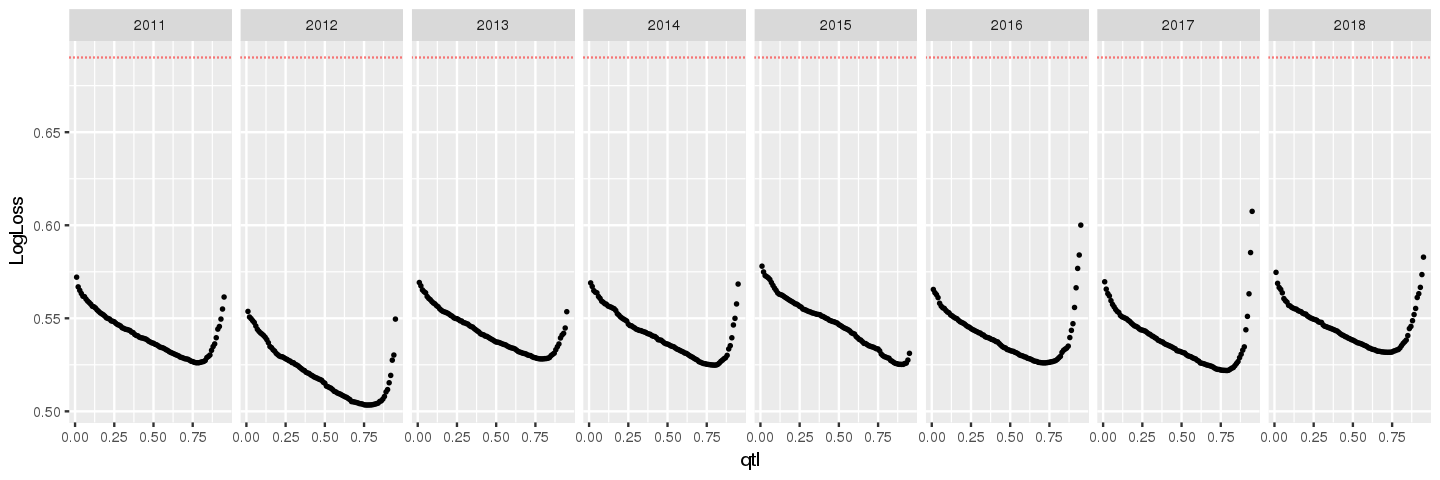

In [26]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data=df.train.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Tourney matchups performance (validation dataset)

#### Load test data

In [27]:
data.valid.matchups <- readRDS('../datafiles_rds/TourneyMatchups.rds')
data.valid.matchups %>% filter(Season>2010) -> data.valid.matchups
data.valid.matchups %>% head

data.valid.truth <- readRDS('../datafiles_rds/TourneyTrueResults.rds')
data.valid.truth %>% sample_n(5)

Season,TeamID.x,TeamID.y
2011,1155,1421
2011,1155,1427
2011,1155,1433
2011,1155,1163
2011,1155,1196
2011,1155,1211


ID,Target
2004_1242_1334,1
2009_1106_1287,0
2011_1155_1412,1
2011_1206_1437,1
2013_1107_1181,0


#### prepare

In [28]:
# matchups dataframe : all the possible matches between the 68 teams per Season 
data.valid.matchups %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.valid.matchups

In [29]:
data.valid.matchups %>% head

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2011,1155,1421,15.0589,14.03182
2011,1155,1427,15.0589,13.80250
2011,1155,1433,15.0589,14.54157
2011,1155,1163,15.0589,15.29155
2011,1155,1196,15.0589,15.23792
2011,1155,1211,15.0589,15.14184


In [35]:
# all matchs with all 80 hyper parameter setting (qtl=[0.01,0.95]) 
data.valid.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> df.valid.matchups
df.valid.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2016,1167,1338,14.29223,15.02270,0.64,1.847265
2011,1106,1437,13.16479,15.20301,0.45,1.346099
2017,1388,1433,15.63731,14.94550,0.58,1.657189
2016,1211,1437,15.16754,15.56301,0.04,1.025738
2013,1235,1243,15.24523,15.08110,0.41,1.277825


In [36]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
df.valid.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.valid.submit
df.valid.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2012,0.44,2012_1104_1246,0,0.251
2018,0.11,2018_1172_1417,1,0.528
2017,0.54,2017_1195_1376,0,0.253
2012,0.83,2012_1249_1455,0,0.086
2017,0.87,2017_1411_1458,0,0.050


In [37]:
# merge prediction and truth
data.valid.truth %>% inner_join(df.valid.submit,by='ID') -> df.valid.results

In [38]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.valid.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.valid.perf
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2011,0.09,40,27,67,0.5970149,0.6242495
2012,0.56,48,19,67,0.7164179,0.5726420
2013,0.66,48,19,67,0.7164179,0.5582839
2014,0.61,43,24,67,0.6417910,0.5648949
2015,0.86,51,16,67,0.7611940,0.5018095
2016,0.60,49,18,67,0.7313433,0.5654998
2017,0.74,46,21,67,0.6865672,0.5084691
2018,0.65,47,20,67,0.7014925,0.5829836


In [39]:
df.valid.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018
Accuracy,0.5970149,0.7164179,0.7164179,0.6417910,0.7611940,0.7313433,0.6865672,0.7014925
Best LogLoss,0.6242495,0.5726420,0.5582839,0.5648949,0.5018095,0.5654998,0.5084691,0.5829836
Best Quantile,0.0900000,0.5600000,0.6600000,0.6100000,0.8600000,0.6000000,0.7400000,0.6500000


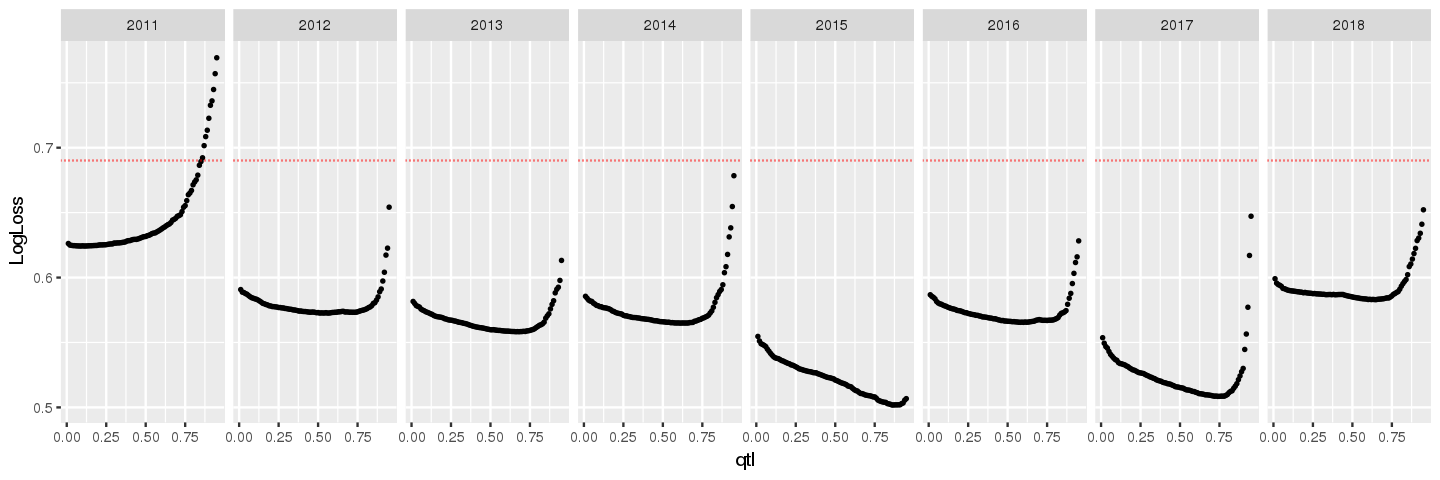

In [40]:
# LogLoss 
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data=df.valid.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Analysis Rating

In [350]:
data.teamtourneyranks <- readRDS('TeamTourneyRanking.rds')
data.tourneyranks <- read.csv('TourneyRanks.csv')

In [351]:
df.ratings %>% 
    filter(Season>2011) %>% 
    inner_join(data.teamtourneyranks,by=c('Season','TeamID')) %>% 
    select(Season,TeamID,Rating,Round) -> df.teamtourneyranks
df.teamtourneyranks %>% arrange(Season,desc(Rating)) %>% head

Season,TeamID,Rating,Round
2012,1326,2171.778,5
2012,1246,2131.496,7
2012,1458,2111.199,3
2012,1242,2061.846,6
2012,1393,2042.822,4
2012,1277,2023.571,3


In [352]:
df.teamtourneyranks %>%
    arrange(desc(Rating)) %>%
    group_by(Season) %>%
    mutate(Rank=row_number()) %>%
    ungroup() %>% 
    inner_join(data.tourneyranks,by='Rank') -> df.teamtourneyranks

In [353]:
df.teamtourneyranks %>% arrange(Season,Rank) %>% head

Season,TeamID,Rating,Round,Rank,RoundTarget
2012,1326,2171.778,5,1,7
2012,1246,2131.496,7,2,6
2012,1458,2111.199,3,3,5
2012,1242,2061.846,6,4,5
2012,1393,2042.822,4,5,4
2012,1277,2023.571,3,6,4


In [354]:
df.teamtourneyranks %>% 
    mutate(Error=(RoundTarget-Round)^2) %>%
    group_by(Season) %>%
    summarise(RMSE=sqrt(mean(Error))) %>% spread(Season,RMSE,sep='_') %>% mutate(Info='RMSE') %>% select(Info,everything())

Info,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018
RMSE,1.084652,1.236694,1.414214,1.071008,1.475287,1.294786,1.382666
